# Exercise 1 - Maximum Entropy Distribution problem with prior assumptions

Consider a random variable $X$ with values in the finite set $\{\alpha_1,\dots,\alpha_n\}$. The distribution of $X$ is characterized by $p$, as $\textbf{prob}(X=\alpha_k)=p_k$. Clearly $p$ satisfies $p\succeq 0$, $\mathbf{1}^\top p=1$. 

The so-called *Maximum Entropy Distribution problem with prior assumptions* can be formulated as

$$
\begin{array}{ll}
\displaystyle \max_{p} & -\sum_{i=1}^n p_i \log(p_i)\\
s.t. & p \in \mathcal{P}.
\end{array}
$$

where $\mathcal{P}$ represents a convex set expressing prior information.

We consider a set of equidistant points $\alpha_i$ in the interval $[-1,1]$:

In [ ]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

#Data
n = 100
alpha = np.linspace(-1,1,n)

And we assume the following prior information:

$$
E(X) \in [-0.1,0.1]
$$
$$
E(X^2) \in [0.5,0.6]
$$
$$
E(3X^3-2X) \in [-0.3,-0.2]
$$
$$
\textbf{prob}(X<0) \in [0.3,0.4]
$$

Recall that $E(f(X)) = \sum_{i} f(\alpha_i) \cdot p_i$ and that $\textbf{prob}(X< 0)$ is given by the Python command `(alpha<0).astype(int)*p`, where `p` is the cp variable.

1.   Solve the Maximum Entropy Distribution problem with prior information (Hint: it is advised that you use the atomic function [entr](https://www.cvxpy.org/api_reference/cvxpy.atoms.elementwise.html?highlight=entr#cvxpy.atoms.elementwise.entr.entr)). What is the optimal value?
2.   Plot $\textbf{prob}(X = \alpha_i)$ vs $\alpha_i$.

## Solution 1

In [ ]:
P = cp.Variable(n)

objective = cp.Maximize(cp.sum(cp.entr(P)))

constraints = [
    P >=0,
    cp.sum(P) == 1,
    cp.sum((alpha @ P)) >= -0.1,
    cp.sum((alpha @ P)) <= 0.1,

    cp.sum(((alpha**2) @ P)) >= 0.5,
    cp.sum(((alpha**2) @ P)) <= 0.6,

    cp.sum(((3*(alpha**3)) @ P - 2*alpha@P)) >= -0.3,
    cp.sum(((3*(alpha**3)) @ P - 2*alpha@P)) <= -0.2,

    cp.sum(((alpha<0).astype(int)@P)) >= 0.3,
    cp.sum(((alpha<0).astype(int)@P)) <= 0.4,
]

prob = cp.Problem(objective,constraints)
prob.solve(verbose=False)
print("status:", prob.status)
print("Optimal value", prob.value)

status: optimal
Optimal value 4.386294336261325


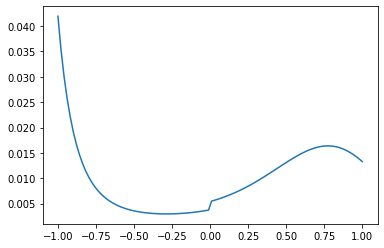

In [ ]:
import matplotlib.pyplot as plt

plt.plot(alpha,P.value)